In [1]:
import pandas as pd

# Load data
filename = "hot_days_2017.csv"
df_combined = pd.read_csv(filename)
print(f"{df_combined.shape[0]} fragrances loaded from {filename}")

731 fragrances loaded from hot_days_2017.csv


In [2]:
# FOR COMBINED FILE ONLY

# df_combined["upvotes"] = df_combined["upvotes_total"]
# df_combined["downvotes"] = df_combined["downvotes_total"]
# df_combined["order"] = df_combined["order_total"]

In [3]:
# View fragrances with either zero upvotes or zero downvotes
# df_combined[(df_combined["upvotes"] == 0) | (df_combined["downvotes"] == 0)]

In [4]:
# Filter out fragrances with either zero upvotes or zero downvotes
df_combined = df_combined[
    (df_combined["upvotes"] != 0) & (df_combined["downvotes"] != 0)
]

# Get rid of bottom 10% of fragrances.
# These are skewed negative due to reinforcement of negative votes
# by being visible at the bottom of the list.
df_combined = df_combined[df_combined["order"] <= df_combined["order"].quantile(0.9)]

# Filter out fragrances with fewer than 10 upvotes
df_combined = df_combined[df_combined["upvotes"] >= 10]

In [5]:
# FOR COMBINED FILE ONLY

# df_combined = df_combined[
#     df_combined[
#         ["order_17", "order_18", "order_19", "order_20", "order_21", "order_22"]
#     ]
#     .notna()
#     .sum(axis=1)
#     == 6
# ]

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Add feature columns
df_combined["total_votes"] = df_combined["upvotes"] + df_combined["downvotes"]
df_combined["vote_diff"] = df_combined["upvotes"] - df_combined["downvotes"]
df_combined["vote_diff_normalized"] = MinMaxScaler().fit_transform(
    np.array(df_combined["vote_diff"]).reshape(-1, 1)
)
df_combined["ratio"] = df_combined["upvotes"] / df_combined["total_votes"]
df_combined["updated_order"] = df_combined["order"].rank()
df_combined["inverse_order"] = df_combined.shape[0] - df_combined["order"].rank() + 1
df_combined["bayes"] = (df_combined["upvotes"] + df_combined["upvotes"].median()) / (
    df_combined["upvotes"]
    + df_combined["upvotes"].median()
    + df_combined["downvotes"]
    + df_combined["downvotes"].median()
)

In [7]:
# Define functions for curve fitting
def linear(x, m, b):
    return m * x + b


def logistic(x, L, k, d):
    return L / (1 + np.exp(-k * (x - d)))


def cubic(x, a, b, c, d):
    return a * pow(x, 3) + b * pow(x, 2) + c * x + d


def exponential(x, a, b, c, d):
    return a * np.exp(b * (x - c)) + d


def logarithmic(x, a, c):
    return a * np.log(x) + c


def rational(x, a, b, c):
    return (a / (b - x)) + c

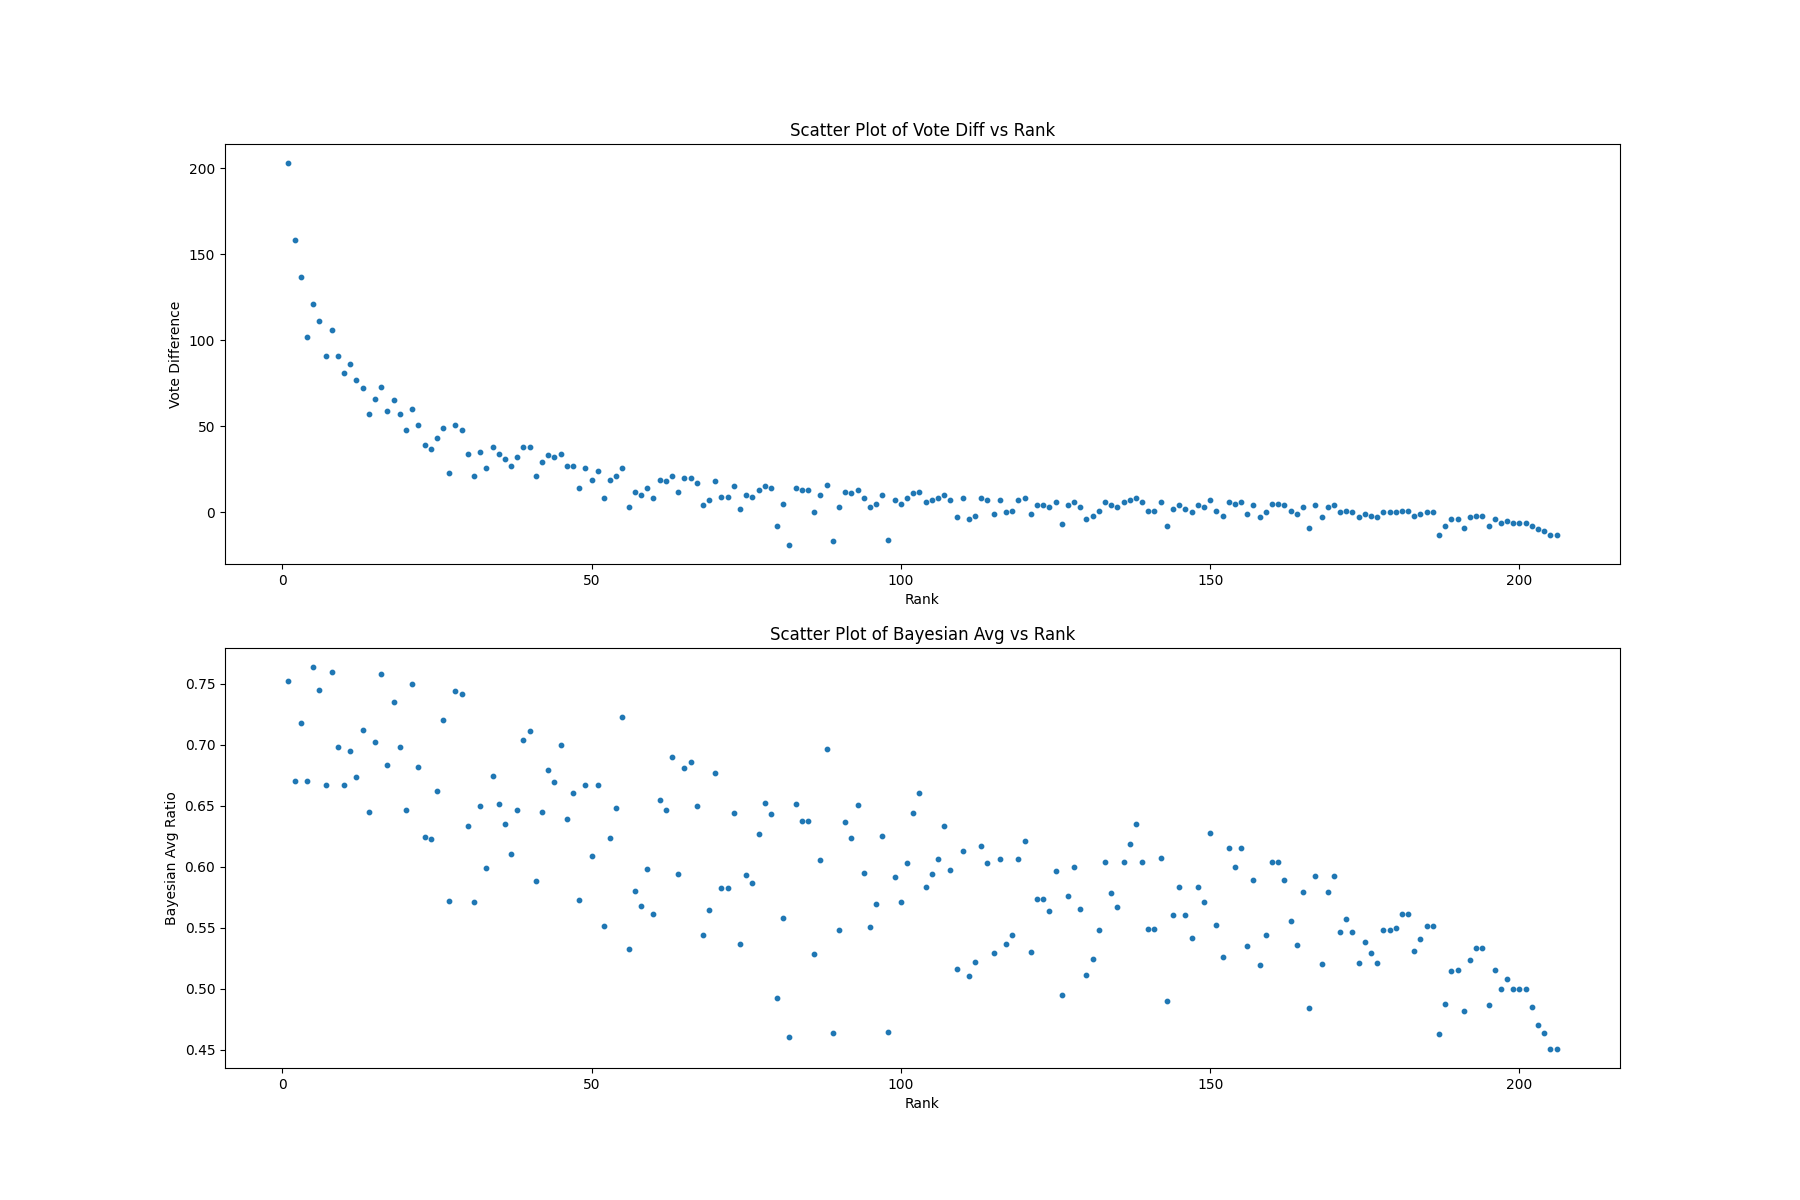

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mplcursors

%matplotlib widget

# Make scatter plot
plt.close("all")
fig, ax = plt.subplots(2, figsize=(18, 12))
ax[0].set_title("Scatter Plot of Vote Diff vs Rank")
ax[0].set(xlabel="Rank")
ax[0].set(ylabel="Vote Difference")

# Plot x and y
y = df_combined["vote_diff"]
# y = y.apply(np.log)
x = df_combined["updated_order"]
# x = x.apply(np.log)
sc1 = ax[0].scatter(x, y, s=10)

y2 = df_combined["bayes"]
sc2 = ax[1].scatter(x, y2, s=10)
ax[1].set_title("Scatter Plot of Bayesian Avg vs Rank")
ax[1].set(xlabel="Rank")
ax[1].set(ylabel="Bayesian Avg Ratio")


# Plot best-fit curve
# fit_function = exponential
# params, covariance = curve_fit(fit_function, x, y, p0=[1, 10, 700, 1])
# print(params)
# xhat = np.linspace(x.min(), x.max(), 100)
# ax[0].plot(xhat, fit_function(xhat, *params), color="k")

# Calculate & plot residuals
# df_combined["yhat"] = fit_function(x, *params)
# df_combined["residual"] = y - df_combined["yhat"]
# sc2 = ax[1].scatter(x, df_combined["residual"], s=10)
# ax[1].axhline(color="k")
# ax[1].set_title("Residual Plot")
# ax[1].set(xlabel="Inverse of Order")
# ax[1].set(ylabel="Residual")

# Add cursors
cursor1 = mplcursors.cursor(sc1, hover=False)
cursor2 = mplcursors.cursor(sc2, hover=False)


@cursor1.connect("add")
@cursor2.connect("add")
def on_add(sel):
    sel.annotation.set(
        text=df_combined[
            ["name", "vote_diff_normalized", "total_votes", "updated_order", "bayes"]
        ]
        .iloc[sel.index]
        .to_string()
    )


# Box plot of residuals to see outliers
# residual_boxplot = df_combined.boxplot("residual", ax=ax[2], vert=False)

# Show figure
plt.show()

In [9]:
# residual_q1 = df_combined["residual"].quantile(0.25)
# residual_q3 = df_combined["residual"].quantile(0.75)
# residual_iqr = residual_q3 - residual_q1

# df_combined[
#     (df_combined["residual"] > (residual_q3 + 1.5 * residual_iqr))
#     | (df_combined["residual"] < (residual_q1 - 1.5 * residual_iqr))
# ].sort_values("residual")